In [110]:
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np


In [3]:
df = pd.read_csv(r'C:\Users\leoqi\Desktop\NUS_Modules\DSE4211\DSE4211-Group-BTC-Day-Trading\data\processed\merged_df_with_signals.csv')

In [4]:
df.columns

Index(['datetime', 'reddit_smoothed_sentiment_weibull_week',
       'news_smoothed_sentiment_weibull_week',
       'tele_smoothed_sentiment_weibull_week', 'Open', 'High', 'Low', 'Close',
       'TOTAL_TRADES', 'TOTAL_TRADES_BUY', 'TOTAL_TRADES_SELL', 'VOLUME',
       'VOLUME_BUY', 'VOLUME_SELL', 'return', 'log_return',
       'hourly_volatility', 'EMA_8', 'EMA_13', 'EMA_21', 'EMA_Signal',
       'EMA_short', 'EMA_long', 'MACD', 'Signal_Line', 'MACD_Signal',
       'MACD_Hist', 'SMA20', 'STD20', 'Upper_BB', 'Lower_BB', 'RSI_14',
       'BB_RSI_Signal', 'RSI_Signal', 'SMA_50', 'SMA_200',
       'GoldenCross_Signal', '%K', '%D', 'Stochastic_Signal', 'OBV',
       'OBV_EMA20', 'OBV_Signal', 'H-L', 'H-PC', 'L-PC', 'TR', 'ATR',
       'reddit_sentiment_log', 'news_sentiment_log', 'tele_sentiment_log',
       'reddit_Signal', 'news_Signal', 'tele_Signal', 'typical_price', 'DATE',
       'VWAP', 'VWAP_Signal'],
      dtype='object')

In [5]:
base_price_data = ['datetime','Close','Open','High','Low','VOLUME']

technical_indicators = [
    # Trend Indicators
    'EMA_8', 'EMA_13', 'EMA_21', 'EMA_Signal', 'EMA_short', 'EMA_long',
    'SMA20', 'SMA_50', 'SMA_200', 'GoldenCross_Signal',

    # Momentum Indicators
    'MACD', 'Signal_Line', 'MACD_Signal', 'MACD_Hist',
    'RSI_14', 'BB_RSI_Signal', 'RSI_Signal',
    '%K', '%D', 'Stochastic_Signal',

    # Volatility Indicators
    'STD20', 'Upper_BB', 'Lower_BB', 'ATR', 'TR',

    # Volume-Based Indicators
    'OBV', 'OBV_EMA20', 'OBV_Signal', 'VWAP_Signal'
]

sentiment_indicators = [
    'reddit_sentiment_log',
    'tele_sentiment_log',
    'news_sentiment_log',
]

# Create a new DataFrame with the selected columns
selected_columns = base_price_data + technical_indicators + sentiment_indicators
df_selected = df[selected_columns]

In [6]:
df_selected

,datetime,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
0,2024-01-27 13:00:00,41742.44,41750.00,41806.55,41725.21,419.38468,41729.550796,41714.525206,41617.761701,1,...,41524.488454,175.710000,81.34,-419.38468,-65.712408,0,-1,0.000000,2.060767,-6.755482
1,2024-01-27 14:00:00,41766.00,41742.44,41818.39,41731.01,493.43458,41737.650619,41721.878748,41631.237910,1,...,41541.267296,140.500000,87.38,493.43458,-12.460314,1,1,0.026643,2.060767,-6.766796
2,2024-01-27 15:00:00,41814.00,41766.00,41894.87,41733.60,581.25856,41754.617148,41735.038927,41647.852645,1,...,41561.147977,109.318333,161.27,581.25856,44.084341,0,1,0.152026,2.060767,-6.776304
3,2024-01-27 16:00:00,41810.18,41814.00,41895.74,41791.22,609.18361,41766.964449,41745.773366,41662.609678,1,...,41571.210298,101.921667,104.52,-609.18361,-18.131655,-1,1,0.262769,2.063227,-6.783594
4,2024-01-27 17:00:00,41779.28,41810.18,41845.34,41774.07,448.23397,41769.701238,41750.560028,41673.216071,1,...,41588.600128,99.801667,71.27,-448.23397,-59.093780,0,-1,0.361376,2.063227,-6.788139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10171,2025-03-26 08:00:00,87959.73,88140.45,88200.00,87886.10,525.11331,87756.884904,87689.841782,87613.211597,1,...,87158.682498,418.066667,313.90,-525.11331,59.670458,-1,1,-0.396829,2.601147,-3.780636
10172,2025-03-26 09:00:00,87939.99,87959.73,88056.61,87837.49,393.09750,87797.574925,87725.577241,87642.918724,1,...,87170.539414,392.118333,219.12,-393.09750,16.549700,0,1,-0.376302,2.601147,-3.692921
10173,2025-03-26 10:00:00,88208.47,87939.99,88259.81,87939.99,556.20541,87888.884942,87794.561921,87694.332477,1,...,87154.234720,378.148333,319.82,556.20541,67.945482,1,1,-0.356054,2.601147,-3.634124
10174,2025-03-26 11:00:00,87954.96,88208.47,88242.00,87923.91,940.31797,87903.568288,87817.475933,87718.025888,1,...,87155.773444,362.111667,318.09,-940.31797,-28.079609,-1,1,-0.336149,2.601147,-3.647040


In [7]:
df_selected['close_t+1'] = df_selected['Close'].shift(-1)
df_selected['close_t+2'] = df_selected['Close'].shift(-2)
df_selected['close_t+4'] = df_selected['Close'].shift(-4)
df_selected['close_t+8'] = df_selected['Close'].shift(-8)

C:\Users\leoqi\AppData\Local\Temp\ipykernel_22476\1322539743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['close_t+1'] = df_selected['Close'].shift(-1)
C:\Users\leoqi\AppData\Local\Temp\ipykernel_22476\1322539743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['close_t+2'] = df_selected['Close'].shift(-2)
C:\Users\leoqi\AppData\Local\Temp\ipykernel_22476\1322539743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [8]:
df_selected[['datetime','Close','close_t+1', 'close_t+2', 'close_t+4', 'close_t+8']].head(10)

,datetime,Close,close_t+1,close_t+2,close_t+4,close_t+8
0,2024-01-27 13:00:00,41742.44,41766.00,41814.00,41779.28,42150.59
1,2024-01-27 14:00:00,41766.00,41814.00,41810.18,41797.62,42155.51
2,2024-01-27 15:00:00,41814.00,41810.18,41779.28,41910.47,42120.63
3,2024-01-27 16:00:00,41810.18,41779.28,41797.62,42059.93,41990.85
4,2024-01-27 17:00:00,41779.28,41797.62,41910.47,42150.59,42100.00
5,2024-01-27 18:00:00,41797.62,41910.47,42059.93,42155.51,42102.22
6,2024-01-27 19:00:00,41910.47,42059.93,42150.59,42120.63,42231.83
7,2024-01-27 20:00:00,42059.93,42150.59,42155.51,41990.85,42720.32
8,2024-01-27 21:00:00,42150.59,42155.51,42120.63,42100.00,42562.44
9,2024-01-27 22:00:00,42155.51,42120.63,41990.85,42102.22,42413.27


In [9]:
df_selected

,datetime,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,...,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log,close_t+1,close_t+2,close_t+4,close_t+8
0,2024-01-27 13:00:00,41742.44,41750.00,41806.55,41725.21,419.38468,41729.550796,41714.525206,41617.761701,1,...,-65.712408,0,-1,0.000000,2.060767,-6.755482,41766.00,41814.00,41779.28,42150.59
1,2024-01-27 14:00:00,41766.00,41742.44,41818.39,41731.01,493.43458,41737.650619,41721.878748,41631.237910,1,...,-12.460314,1,1,0.026643,2.060767,-6.766796,41814.00,41810.18,41797.62,42155.51
2,2024-01-27 15:00:00,41814.00,41766.00,41894.87,41733.60,581.25856,41754.617148,41735.038927,41647.852645,1,...,44.084341,0,1,0.152026,2.060767,-6.776304,41810.18,41779.28,41910.47,42120.63
3,2024-01-27 16:00:00,41810.18,41814.00,41895.74,41791.22,609.18361,41766.964449,41745.773366,41662.609678,1,...,-18.131655,-1,1,0.262769,2.063227,-6.783594,41779.28,41797.62,42059.93,41990.85
4,2024-01-27 17:00:00,41779.28,41810.18,41845.34,41774.07,448.23397,41769.701238,41750.560028,41673.216071,1,...,-59.093780,0,-1,0.361376,2.063227,-6.788139,41797.62,41910.47,42150.59,42100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10171,2025-03-26 08:00:00,87959.73,88140.45,88200.00,87886.10,525.11331,87756.884904,87689.841782,87613.211597,1,...,59.670458,-1,1,-0.396829,2.601147,-3.780636,87939.99,88208.47,87813.17,NaN
10172,2025-03-26 09:00:00,87939.99,87959.73,88056.61,87837.49,393.09750,87797.574925,87725.577241,87642.918724,1,...,16.549700,0,1,-0.376302,2.601147,-3.692921,88208.47,87954.96,NaN,NaN
10173,2025-03-26 10:00:00,88208.47,87939.99,88259.81,87939.99,556.20541,87888.884942,87794.561921,87694.332477,1,...,67.945482,1,1,-0.356054,2.601147,-3.634124,87954.96,87813.17,NaN,NaN
10174,2025-03-26 11:00:00,87954.96,88208.47,88242.00,87923.91,940.31797,87903.568288,87817.475933,87718.025888,1,...,-28.079609,-1,1,-0.336149,2.601147,-3.647040,87813.17,NaN,NaN,NaN


In [45]:
df_selected.isna().sum()

datetime                0
Close                   0
Open                    0
High                    0
Low                     0
VOLUME                  0
EMA_8                   0
EMA_13                  0
EMA_21                  0
EMA_Signal              0
EMA_short               0
EMA_long                0
SMA20                   0
SMA_50                  0
SMA_200                 0
GoldenCross_Signal      0
MACD                    0
Signal_Line             0
MACD_Signal             0
MACD_Hist               0
RSI_14                  0
BB_RSI_Signal           0
RSI_Signal              0
%K                      0
%D                      0
Stochastic_Signal       0
STD20                   0
Upper_BB                0
Lower_BB                0
ATR                     0
TR                      0
OBV                     0
OBV_EMA20               0
OBV_Signal              0
VWAP_Signal             0
reddit_sentiment_log    0
tele_sentiment_log      0
news_sentiment_log      0
close_t+1   

In [46]:
df_selected = df_selected.dropna()

In [47]:
df_copy = df_selected.copy()

In [48]:
def sequencing_data(df, window_size=7):
    def process_grouped(group):
        samples = pd.DataFrame()
        group = group.reset_index(drop=True)

        for idx in group.index[window_size:]:
            sample = {}
            past_data = group.loc[idx - window_size:idx - 1]

            # Timestamp
            inference_date = group.iloc[idx]['datetime']

            # Past Features
            past_features = {
                'past_high': list(past_data['High']),
                'past_low': list(past_data['Low']),
                'past_open': list(past_data['Open']),
                'past_volume': list(past_data['VOLUME'])
            }

            # Technical Indicators
            for indicator in [
                'EMA_8', 'EMA_13', 'EMA_21', 'EMA_Signal', 'EMA_short', 'EMA_long',
                'SMA20', 'SMA_50', 'SMA_200', 'GoldenCross_Signal',
                'MACD', 'Signal_Line', 'MACD_Signal', 'MACD_Hist',
                'RSI_14', 'BB_RSI_Signal', 'RSI_Signal',
                '%K', '%D', 'Stochastic_Signal',
                'STD20', 'Upper_BB', 'Lower_BB', 'ATR', 'TR',
                'OBV', 'OBV_EMA20', 'OBV_Signal', 'VWAP_Signal'
            ]:
                past_features[f'past_{indicator}'] = list(past_data[indicator])

            # Sentiment Indicators
            for sentiment in ['reddit_sentiment_log', 'tele_sentiment_log', 'news_sentiment_log']:
                past_features[f'past_{sentiment}'] = list(past_data[sentiment])

            # Target
            target = [
                group.iloc[idx]['close_t+1'],
                group.iloc[idx]['close_t+2'],
                group.iloc[idx]['close_t+4'],
                group.iloc[idx]['close_t+8']
            ]

            sample = {'inference_date': inference_date, **past_features, 'target': target}
            samples = pd.concat([samples, pd.DataFrame([sample])], ignore_index=True)

        return samples

    # Process the data without grouping, just directly use the DataFrame
    samples = process_grouped(df)

    return samples

In [49]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset

class FinDataset(Dataset):

    def __init__(self, frame, look_back_window, look_ahead_window, transform=None):
        self.frame = frame
        self.look_back_window = look_back_window
        self.look_ahead_window = look_ahead_window

        if look_back_window <= 0:
            raise ValueError("Please specify a valid timeframe of data to train on")

        # if look_ahead_window <= 0:
        #     raise ValueError("Please choose a valid h for h-step-ahead-forecast")

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        data = self.frame.iloc[idx]

        look_back_idx = self.look_back_window 
        look_ahead_idx = self.look_ahead_window

        # Basic features
        past_high = np.array(data['past_high'][-look_back_idx:])
        past_low = np.array(data['past_low'][-look_back_idx:])
        past_open = np.array(data['past_open'][-look_back_idx:])
        past_volume = np.array(data['past_volume'][-look_back_idx:])
        basic = np.concatenate([past_high, past_low, past_open, past_volume])

        # Technical indicators
        technical_indicators = [
            'EMA_8', 'EMA_13', 'EMA_21', 'EMA_Signal', 'EMA_short', 'EMA_long',
            'SMA20', 'SMA_50', 'SMA_200', 'GoldenCross_Signal',
            'MACD', 'Signal_Line', 'MACD_Signal', 'MACD_Hist',
            'RSI_14', 'BB_RSI_Signal', 'RSI_Signal',
            '%K', '%D', 'Stochastic_Signal',
            'STD20', 'Upper_BB', 'Lower_BB', 'ATR', 'TR',
            'OBV', 'OBV_EMA20', 'OBV_Signal', 'VWAP_Signal'
        ]
        
        technical_features = []
        for indicator in technical_indicators:
            technical_features.append(np.array(data[f'past_{indicator}'][-look_back_idx:]))
        technical = np.concatenate(technical_features)

        # Sentiment indicators
        sentiment_indicators = [
            'reddit_sentiment_log', 'tele_sentiment_log', 'news_sentiment_log'
        ]
        
        sentiment_features = []
        for sentiment in sentiment_indicators:
            sentiment_features.append(np.array(data[f'past_{sentiment}'][-look_back_idx:]))
        sentiment = np.concatenate(sentiment_features)

        # Full inputs
        inputs = np.concatenate([basic, technical, sentiment])

        # Target (next 4 closes)
        target = data['target']

        return np.float32(inputs), np.float32(target)


In [50]:
sequenced = sequencing_data(df_copy,window_size = 7)

In [51]:
sequenced

,inference_date,past_high,past_low,past_open,past_volume,past_EMA_8,past_EMA_13,past_EMA_21,past_EMA_Signal,past_EMA_short,...,past_ATR,past_TR,past_OBV,past_OBV_EMA20,past_OBV_Signal,past_VWAP_Signal,past_reddit_sentiment_log,past_tele_sentiment_log,past_news_sentiment_log,target
0,2024-01-27 20:00:00,"[41806.55, 41818.39, 41894.87, 41895.74, 41845...","[41725.21, 41731.01, 41733.6, 41791.22, 41774....","[41750.0, 41742.44, 41766.0, 41814.0, 41810.18...","[419.38468, 493.43458, 581.25856, 609.18361, 4...","[41729.55079583185, 41737.650618980326, 41754....","[41714.52520589108, 41721.87874790664, 41735.0...","[41617.7617009544, 41631.23790995855, 41647.85...","[1, 1, 1, 1, 1, 1, 1]","[41720.54130165787, 41727.534947556655, 41740....",...,"[175.71000000000154, 140.50000000000122, 109.3...","[81.34000000000378, 87.37999999999738, 161.270...","[-419.38468, 493.43458, 581.25856, -609.18361,...","[-65.71240799305417, -12.460313898477589, 44.0...","[0, 1, 0, -1, 0, 1, 0]","[-1, 1, 1, 1, -1, 1, 1]","[0.0, 0.0266425795623465, 0.152026036471607, 0...","[2.060767095239432, 2.060767095239432, 2.06076...","[-6.755482399542175, -6.766795995954805, -6.77...","[42150.59, 42155.51, 41990.85, 42720.32]"
1,2024-01-27 21:00:00,"[41818.39, 41894.87, 41895.74, 41845.34, 41817...","[41731.01, 41733.6, 41791.22, 41774.07, 41745....","[41742.44, 41766.0, 41814.0, 41810.18, 41779.2...","[493.43458, 581.25856, 609.18361, 448.23397, 3...","[41737.650618980326, 41754.61714809581, 41766....","[41721.87874790664, 41735.03892677712, 41745.7...","[41631.23790995855, 41647.85264541686, 41662.6...","[1, 1, 1, 1, 1, 1, 1]","[41727.534947556655, 41740.83726331717, 41751....",...,"[140.50000000000122, 109.31833333333512, 101.9...","[87.37999999999738, 161.27000000000407, 104.51...","[493.43458, 581.25856, -609.18361, -448.23397,...","[-12.460313898477589, 44.08434075852027, -18.1...","[1, 0, -1, 0, 1, 0, 0]","[1, 1, 1, -1, 1, 1, 1]","[0.0266425795623465, 0.152026036471607, 0.2627...","[2.060767095239432, 2.060767095239432, 2.06322...","[-6.766795995954805, -6.776304427268962, -6.78...","[42155.51, 42120.63, 42100.0, 42562.44]"
2,2024-01-27 22:00:00,"[41894.87, 41895.74, 41845.34, 41817.64, 41986...","[41733.6, 41791.22, 41774.07, 41745.26, 41790....","[41766.0, 41814.0, 41810.18, 41779.28, 41797.6...","[581.25856, 609.18361, 448.23397, 392.55791, 8...","[41754.61714809581, 41766.96444851896, 41769.7...","[41735.03892677712, 41745.77336580896, 41750.5...","[41647.85264541686, 41662.60967765169, 41673.2...","[1, 1, 1, 1, 1, 1, 1]","[41740.83726331717, 41751.50537665299, 41755.7...",...,"[109.31833333333512, 101.92166666666768, 99.80...","[161.27000000000407, 104.5199999999968, 71.269...","[581.25856, -609.18361, -448.23397, 392.55791,...","[44.08434075852027, -18.131654551815, -59.0937...","[0, -1, 0, 1, 0, 0, 0]","[1, 1, -1, 1, 1, 1, 1]","[0.152026036471607, 0.2627692568272025, 0.3613...","[2.060767095239432, 2.063227001489746, 2.06322...","[-6.776304427268962, -6.783593745345505, -6.78...","[42120.63, 41990.85, 42102.22, 42413.27]"
3,2024-01-27 23:00:00,"[41895.74, 41845.34, 41817.64, 41986.06, 42076...","[41791.22, 41774.07, 41745.26, 41790.87, 41910...","[41814.0, 41810.18, 41779.28, 41797.62, 41910....","[609.18361, 448.23397, 392.55791, 806.22964, 6...","[41766.96444851896, 41769.70123773697, 41775.9...","[41745.77336580896, 41750.56002783625, 41757.2...","[41662.60967765169, 41673.21607059245, 41684.5...","[1, 1, 1, 1, 1, 1, 1]","[41751.50537665299, 41755.77839562945, 41762.2...",...,"[101.92166666666768, 99.80166666666628, 96.359...","[104.5199999999968, 71.2699999999968, 72.37999...","[-609.18361, -448.23397, 392.55791, 806.22964,...","[-18.131654551815, -59.093779832594514, -16.07...","[-1, 0, 1, 0, 0, 0, 0]","[1, -1, 1, 1, 1, 1, 1]","[0.2627692568272025, 0.3613759079017221, 0.449...","[2.063227001489746, 2.063227001489746, 2.06322...","[-6.783593745345505, -6.788138502412967, -6.79...","[41990.85, 42100.0, 42231.83, 42388.82]"
4,2024-01-28 00:00:00,"[418

In [52]:
import multiprocessing as mp
print("Available Workers:", mp.cpu_count())

Available Workers: 24


In [53]:
dataset = FinDataset(sequenced,7,0)
dataloader = DataLoader(dataset,batch_size = 256 ,shuffle = False)
inputs = None
outputs = None
for i, (x, y) in enumerate(dataloader):
    if inputs is None:
        inputs = x  # Initialize inputs with the shape of x
        outputs = y  # Initialize outputs with the shape of y
    else:
        inputs = np.concatenate([inputs, x])
        outputs = np.concatenate([outputs, y])

In [54]:
inputs.shape, outputs.shape

((10161, 252), (10161, 4))

In [55]:
labels =sequenced [['inference_date']]
labels.to_parquet(f'../data/processed/labels_btc.parquet', index=False)

np.save(f'../data/processed/inputs_btc.npy',inputs)

np.save(f'../data/processed/outputs_btc.npy',outputs)

In [62]:
labels[(labels['inference_date'] >= '2025-01-01') & (labels['inference_date'] < '2025-03-01')]

,inference_date
8140,2025-01-01 00:00:00
8141,2025-01-01 01:00:00
8142,2025-01-01 02:00:00
8143,2025-01-01 03:00:00
8144,2025-01-01 04:00:00
...,...
9551,2025-02-28 19:00:00
9552,2025-02-28 20:00:00
9553,2025-02-28 21:00:00
9554,2025-02-28 22:00:00


In [71]:
X_train, X_val,X_test = inputs[:8140], inputs[8140:9556], inputs[9556:]
y_train, y_val,y_test = outputs[:8140], outputs[8140:9556], outputs[9556:]

In [73]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(8140, 252) (8140, 4)
(1416, 252) (1416, 4)
(605, 252) (605, 4)


In [76]:
def objective(trial):
    # Define the hyperparameters
    param = {
        'objective': 'reg:squarederror',  # Regression task
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'lambda': trial.suggest_float('lambda', 1e-5, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-5, 1.0)
    }

    # Train the XGBoost model with the suggested hyperparameters
    model = xgb.XGBRegressor(**param)

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    preds = model.predict(X_val)

    # Calculate RMSE (Root Mean Squared Error) as evaluation metric
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse


In [77]:
# Optuna study to optimize hyperparameters
study = optuna.create_study(direction='minimize')  # Minimize the RMSE
study.optimize(objective, n_trials=100)

[I 2025-04-02 13:37:43,677] A new study created in memory with name: no-name-64932ee5-4a80-4bf0-97c9-9f4c72546d17
[I 2025-04-02 13:37:44,589] Trial 0 finished with value: 1694.8856156095019 and parameters: {'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.09007238031115677, 'subsample': 0.7952239214714332, 'colsample_bytree': 0.7296561078389874, 'gamma': 3.387305883190759, 'min_child_weight': 6, 'lambda': 0.8667070054041156, 'alpha': 0.2618560602627204}. Best is trial 0 with value: 1694.8856156095019.
[I 2025-04-02 13:37:50,930] Trial 1 finished with value: 1805.6127768710544 and parameters: {'n_estimators': 461, 'max_depth': 5, 'learning_rate': 0.045994002407471556, 'subsample': 0.8724947642981385, 'colsample_bytree': 0.6498519093523674, 'gamma': 4.304255233989472, 'min_child_weight': 7, 'lambda': 0.3292175386526309, 'alpha': 0.11092653539157343}. Best is trial 0 with value: 1694.8856156095019.
[I 2025-04-02 13:38:18,096] Trial 2 finished with value: 2201.835938484064 and parame

In [80]:
#combined set X_train, y_train with X_val, y_val

X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

In [ ]:
# Print the best hyperparameters
print("Best Hyperparameters:", study.best_params)

# Train the model with the best hyperparameters
best_model = xgb.XGBRegressor(**study.best_params)
best_model.fit(X_combined, y_combined)

# Evaluate the model on the test set
predictions = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Test RMSE after Hyperparameter Tuning:", rmse)

Best Hyperparameters: {'n_estimators': 97, 'max_depth': 3, 'learning_rate': 0.08912336294162741, 'subsample': 0.6275995198251672, 'colsample_bytree': 0.9536096693290075, 'gamma': 0.8347411416322221, 'min_child_weight': 8, 'lambda': 0.9383929771918788, 'alpha': 0.12994821871433693}
Test RMSE after Hyperparameter Tuning: 1582.4710107929307


In [114]:
best_model.save_model('xgboost_model.json')

In [82]:
y_test

array([[84656.93, 85240.46, 86190.01, 85303.37],
       [85240.46, 85330.84, 85588.19, 85380.  ],
       [85330.84, 86190.01, 85075.62, 84900.01],
       ...,
       [87153.51, 87326.78, 87909.07, 88208.47],
       [87326.78, 87520.35, 88140.45, 87954.96],
       [87520.35, 87909.07, 87959.73, 87813.17]],
      shape=(605, 4), dtype=float32)

In [83]:
predictions

array([[84126.49 , 84278.234, 84227.96 , 84005.83 ],
       [84071.21 , 84267.01 , 84064.68 , 83547.37 ],
       [84257.44 , 84328.68 , 84123.445, 83535.4  ],
       ...,
       [87288.19 , 88362.836, 88242.28 , 87606.78 ],
       [87204.086, 88158.33 , 88096.57 , 87426.4  ],
       [87214.65 , 88036.64 , 88006.01 , 87415.05 ]],
      shape=(605, 4), dtype=float32)

In [94]:
labels[labels['inference_date'] >= '2025-03-01']

,inference_date
9556,2025-03-01 00:00:00
9557,2025-03-01 01:00:00
9558,2025-03-01 02:00:00
9559,2025-03-01 03:00:00
9560,2025-03-01 04:00:00
...,...
10156,2025-03-26 00:00:00
10157,2025-03-26 01:00:00
10158,2025-03-26 02:00:00
10159,2025-03-26 03:00:00


In [105]:
a = df_copy[df_copy['datetime'] >= '2025-03-01'][['datetime', 'Close']].reset_index(drop=True)
a

,datetime,Close
0,2025-03-01 00:00:00,83857.92
1,2025-03-01 01:00:00,84656.93
2,2025-03-01 02:00:00,85240.46
3,2025-03-01 03:00:00,85330.84
4,2025-03-01 04:00:00,86190.01
...,...,...
600,2025-03-26 00:00:00,87652.00
601,2025-03-26 01:00:00,87836.04
602,2025-03-26 02:00:00,87324.60
603,2025-03-26 03:00:00,87153.51


In [128]:
y_test_df = pd.DataFrame(y_test, columns=['close_t+1', 'close_t+2', 'close_t+4', 'close_t+8']).reset_index(drop=True)
pred_df = pd.DataFrame(predictions, columns=['pred_close_t+1', 'pred_close_t+2', 'pred_close_t+4', 'pred_close_t+8']).reset_index(drop=True)

ab = pd.concat([a, y_test_df, pred_df], axis=1)
ab

,datetime,Close,close_t+1,close_t+2,close_t+4,close_t+8,pred_close_t+1,pred_close_t+2,pred_close_t+4,pred_close_t+8
0,2025-03-01 00:00:00,83857.92,84656.929688,85240.460938,86190.007812,85303.367188,84126.492188,84278.234375,84227.960938,84005.828125
1,2025-03-01 01:00:00,84656.93,85240.460938,85330.843750,85588.187500,85380.000000,84071.210938,84267.007812,84064.679688,83547.367188
2,2025-03-01 02:00:00,85240.46,85330.843750,86190.007812,85075.617188,84900.007812,84257.437500,84328.679688,84123.445312,83535.398438
3,2025-03-01 03:00:00,85330.84,86190.007812,85588.187500,84740.148438,84632.789062,84409.015625,84401.578125,84046.257812,83736.507812
4,2025-03-01 04:00:00,86190.01,85588.187500,85075.617188,85303.367188,84758.859375,85942.273438,86028.265625,85870.109375,85420.023438
...,...,...,...,...,...,...,...,...,...,...
600,2025-03-26 00:00:00,87652.00,87836.039062,87324.601562,87326.781250,87959.726562,87197.515625,88274.796875,87312.468750,86973.257812
601,2025-03-26 01:00:00,87836.04,87324.601562,87153.507812,87520.351562,87939.992188,87338.250000,88264.796875,88000.460938,87100.406250
602,2025-03-26 02:00:00,87324.60,87153.507812,87326.781250,87909.070312,88208.468750,87288.187500,88362.835938,88242.281250,87606.781250
603,2025-03-26 03:00:00,87153.51,87326.781250,87520.351562,88140.453125,87954.960938,87204.085938,88158.328125,88096.570312,87426.398438


In [129]:
def determine_signal_pred(row):
    # Count how many of the forecasted values are greater than the actual Close value
    positive_predictions = sum([
        row['pred_close_t+1'] > row['Close'],
        row['pred_close_t+2'] > row['Close'],
        row['pred_close_t+4'] > row['Close'],
        row['pred_close_t+8'] > row['Close']
    ])
    
    # If 3 or more predictions are greater than Close, return 1, else return 0
    return 1 if positive_predictions >= 3 else 0

def determine_signal_actual(row):
    # Count how many of the forecasted values are greater than the actual Close value
    positive_predictions = sum([
        row['close_t+1'] > row['Close'],
        row['close_t+2'] > row['Close'],
        row['close_t+4'] > row['Close'],
        row['close_t+8'] > row['Close']
    ])
    
    # If 3 or more predictions are greater than Close, return 1, else return 0
    return 1 if positive_predictions >= 3 else 0

In [130]:
ab['buy_pred_signal'] = ab.apply(determine_signal_pred, axis=1)
ab['buy_actual_signal'] = ab.apply(determine_signal_actual, axis=1)

In [131]:
ab

,datetime,Close,close_t+1,close_t+2,close_t+4,close_t+8,pred_close_t+1,pred_close_t+2,pred_close_t+4,pred_close_t+8,buy_pred_signal,buy_actual_signal
0,2025-03-01 00:00:00,83857.92,84656.929688,85240.460938,86190.007812,85303.367188,84126.492188,84278.234375,84227.960938,84005.828125,1,1
1,2025-03-01 01:00:00,84656.93,85240.460938,85330.843750,85588.187500,85380.000000,84071.210938,84267.007812,84064.679688,83547.367188,0,1
2,2025-03-01 02:00:00,85240.46,85330.843750,86190.007812,85075.617188,84900.007812,84257.437500,84328.679688,84123.445312,83535.398438,0,0
3,2025-03-01 03:00:00,85330.84,86190.007812,85588.187500,84740.148438,84632.789062,84409.015625,84401.578125,84046.257812,83736.507812,0,0
4,2025-03-01 04:00:00,86190.01,85588.187500,85075.617188,85303.367188,84758.859375,85942.273438,86028.265625,85870.109375,85420.023438,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
600,2025-03-26 00:00:00,87652.00,87836.039062,87324.601562,87326.781250,87959.726562,87197.515625,88274.796875,87312.468750,86973.257812,0,0
601,2025-03-26 01:00:00,87836.04,87324.601562,87153.507812,87520.351562,87939.992188,87338.250000,88264.796875,88000.460938,87100.406250,0,0
602,2025-03-26 02:00:00,87324.60,87153.507812,87326.781250,87909.070312,88208.468750,87288.187500,88362.835938,88242.281250,87606.781250,1,1
603,2025-03-26 03:00:00,87153.51,87326.781250,87520.351562,88140.453125,87954.960938,87204.085938,88158.328125,88096.570312,87426.398438,1,1


In [132]:
number_of_actual_signals = ab['buy_actual_signal'].sum()
number_of_pred_signals = ab['buy_pred_signal'].sum()

print("Number of Actual Signals (1):", number_of_actual_signals)
print("Number of Predicted Signals (1):", number_of_pred_signals)

Number of Actual Signals (1): 268
Number of Predicted Signals (1): 311


In [133]:
def determine_signal_pred(row):
    # Count how many of the forecasted values are greater than the actual Close value
    negative_predictions = sum([
        row['pred_close_t+1'] < row['Close'],
        row['pred_close_t+2'] < row['Close'],
        row['pred_close_t+4'] < row['Close'],
        row['pred_close_t+8'] < row['Close']
    ])
    
    # If 3 or more predictions are greater than Close, return 1, else return 0
    return 1 if negative_predictions >= 3 else 0

def determine_signal_actual(row):
    # Count how many of the forecasted values are greater than the actual Close value
    negative_predictions = sum([
        row['close_t+1'] < row['Close'],
        row['close_t+2'] < row['Close'],
        row['close_t+4'] < row['Close'],
        row['close_t+8'] < row['Close']
    ])
    
    # If 3 or more predictions are greater than Close, return 1, else return 0
    return 1 if negative_predictions >= 3 else 0

In [134]:
ab['sell_pred_signal'] = ab.apply(determine_signal_pred, axis=1)
ab['sell_actual_signal'] = ab.apply(determine_signal_actual, axis=1)

In [135]:
number_of_actual_signals = ab['sell_actual_signal'].sum()
number_of_pred_signals = ab['sell_pred_signal'].sum()

print("Number of Actual Signals (1):", number_of_actual_signals)
print("Number of Predicted Signals (1):", number_of_pred_signals)

Number of Actual Signals (1): 233
Number of Predicted Signals (1): 224


In [136]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

buy_cm = confusion_matrix(ab['buy_actual_signal'], ab['buy_pred_signal'])
sell_cm = confusion_matrix(ab['sell_actual_signal'], ab['sell_pred_signal'])

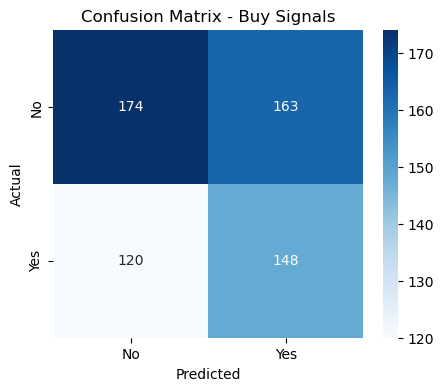

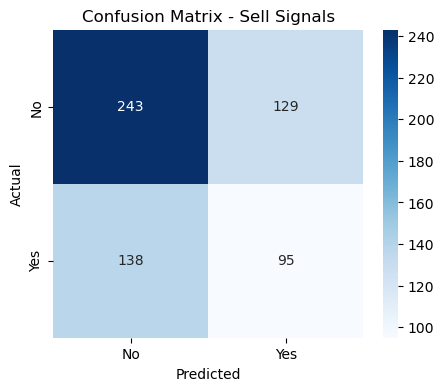

In [137]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(buy_cm, "Confusion Matrix - Buy Signals")
plot_confusion_matrix(sell_cm, "Confusion Matrix - Sell Signals")

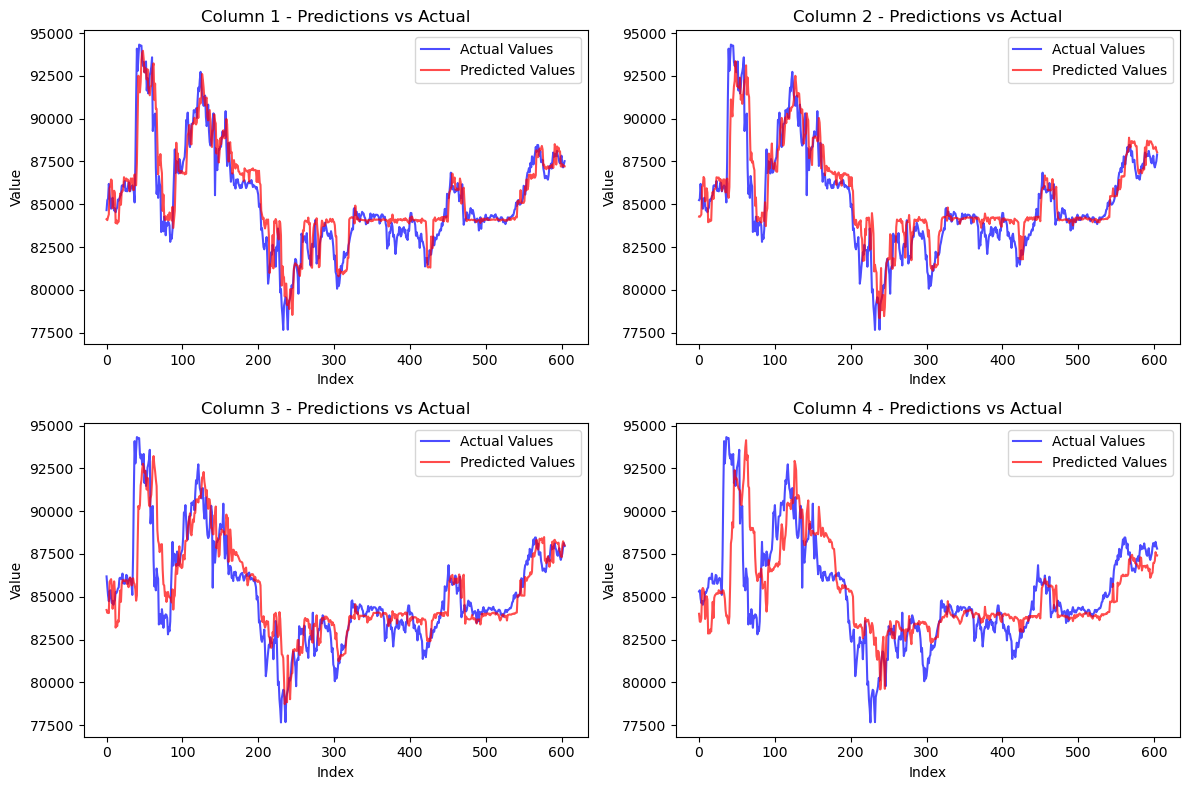

In [ ]:
plt.figure(figsize=(12, 8))

for i in range(4):
    plt.subplot(2, 2, i+1)  # 2 rows, 2 columns, subplot for each
    plt.plot(y_test[:, i], label='Actual Values', color='blue', alpha=0.7)
    plt.plot(predictions[:, i], label='Predicted Values', color='red', alpha=0.7)
    plt.title(f'Column {i+1} - Predictions vs Actual')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()